<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#データ準備" data-toc-modified-id="データ準備-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>データ準備</a></span></li><li><span><a href="#データ確認" data-toc-modified-id="データ確認-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>データ確認</a></span><ul class="toc-item"><li><span><a href="#レポート" data-toc-modified-id="レポート-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>レポート</a></span></li><li><span><a href="#グラフ" data-toc-modified-id="グラフ-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>グラフ</a></span><ul class="toc-item"><li><span><a href="#コレログラム" data-toc-modified-id="コレログラム-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>コレログラム</a></span></li></ul></li><li><span><a href="#定常性の確認" data-toc-modified-id="定常性の確認-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>定常性の確認</a></span></li><li><span><a href="#成分分解" data-toc-modified-id="成分分解-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>成分分解</a></span></li><li><span><a href="#差分系列+季節調整" data-toc-modified-id="差分系列+季節調整-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>差分系列+季節調整</a></span></li><li><span><a href="#PV-/-エントリ数" data-toc-modified-id="PV-/-エントリ数-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>PV / エントリ数</a></span></li></ul></li><li><span><a href="#予測" data-toc-modified-id="予測-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>予測</a></span><ul class="toc-item"><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>SARIMA</a></span><ul class="toc-item"><li><span><a href="#arma_order_select_ic" data-toc-modified-id="arma_order_select_ic-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>arma_order_select_ic</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%matplotlib inline

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import statsmodels.api as sm
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

init_notebook_mode(connected=True)
save_image = None # 'png' if save image

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/yusuke/.anyenv/envs/pyenv/versions/3.6.5/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yusuke/.anyenv/envs/pyenv/versions/3.6.5/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/traitlets

# データ準備

* dataはfloatにしておく
    * `TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'`
* indexはdate_rangeで作ったほうが良い
    * 重複があると（抜け漏れも？）モデリングのときエラーが発生する
    * `ValueError: There is no frequency for these dates and date 2018-04-01 00:00:00 is not in dates index. Try giving a date that is in the dates index or use an integer`

In [2]:
data_file = '../data/processed/data.csv'
df = pd.read_csv(data_file)

df.date = pd.to_datetime(df.date)
df = df.set_index('date')
date_index = pd.date_range('2017-10-01', end='2018-04-30', freq='D')
df = df.reindex(date_index)

df.pv = df.pv.astype(np.float64)
df['log_pv'] = np.log(df.pv)

In [3]:
print(df.pv.head())

2017-10-01     2.0
2017-10-02     9.0
2017-10-03     3.0
2017-10-04    21.0
2017-10-05    13.0
Freq: D, Name: pv, dtype: float64


In [4]:
df.head()

,pv,entry,pv_per_entry,log_pv
2017-10-01,2.0,8,0.250,0.693147
2017-10-02,9.0,8,1.125,2.197225
2017-10-03,3.0,8,0.375,1.098612
2017-10-04,21.0,8,2.625,3.044522
2017-10-05,13.0,8,1.625,2.564949


In [5]:
df.dtypes

pv              float64
entry             int64
pv_per_entry    float64
log_pv          float64
dtype: object

In [6]:
df_train = df[df.index < '2018-04-01']
df_test = df[df.index >= '2018-04-01']

# データ確認

## レポート

In [7]:
pdp.ProfileReport(df)

Number of variables,5
Number of observations,212
Total Missing (%),0.0%
Total size in memory,8.4 KiB
Average record size in memory,40.4 B
Numeric,3
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,1


## グラフ

In [8]:
data = [Scatter(x=df.index, y=df.pv, name='pv')]
fig = Figure(data=data, layout=Layout(title='PV数'))
iplot(fig, image=save_image, filename='PV数')

In [9]:
fig = tools.make_subplots(rows=3, cols=1)
fig.append_trace(Scatter(x=df.index, y=df.pv, name='pv'), 1, 1)
fig.append_trace(Scatter(x=df.index, y=df.log_pv, name='pv(log)'), 2, 1)
fig.append_trace(Scatter(x=df.index, y=df.pv.diff(), name='pv(diff)'), 3, 1)
fig['layout'].update(title='PV数の推移')
iplot(fig, image=save_image, filename='PV数の推移')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [10]:
df.pv.index[:-1]

DatetimeIndex(['2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04',
               '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08',
               '2017-10-09', '2017-10-10',
               ...
               '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23',
               '2018-04-24', '2018-04-25', '2018-04-26', '2018-04-27',
               '2018-04-28', '2018-04-29'],
              dtype='datetime64[ns]', length=211, freq='D')

In [11]:
data = [Scatter(x=df.pv[:-1], y=df.pv[1:], mode='markers')]
corr = np.corrcoef(df.pv[:-1], df.pv[1:])[0][1]
fig = Figure(data=data, layout=Layout(title='ラグ1の散布図(corr={:.2})'.format(corr)))
iplot(fig, image=save_image, filename='ラグ1の散布図')

### コレログラム

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



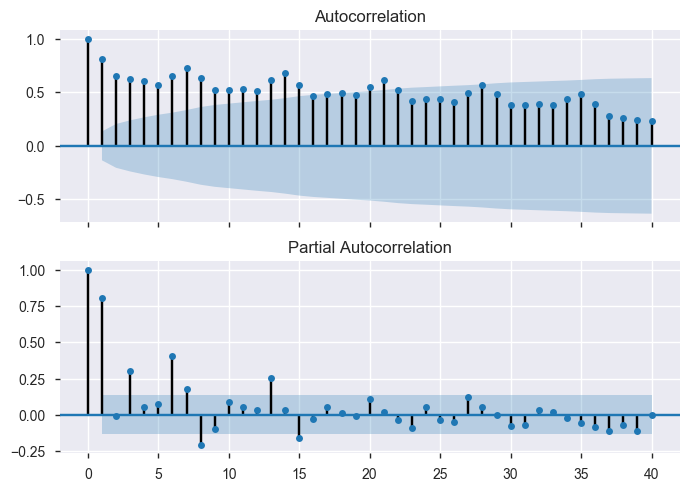

In [12]:
n = 40

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
sm.graphics.tsa.plot_acf(df.pv, lags=n, ax=ax1)
sm.graphics.tsa.plot_pacf(df.pv, lags=n, ax=ax2)
if save_image:
    fig.savefig('コレログラム1.png')

acf = sm.tsa.stattools.acf(df.pv, nlags=n)
pacf = sm.tsa.stattools.pacf(df.pv, nlags=n, method='ywm')

fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(Bar(y=acf, name='自己相関'), 1, 1)
fig.append_trace(Bar(y=pacf, name='偏自己相関'), 2, 1)
fig['layout'].update(
    title='コレログラム',
    shapes=[{
        'xref': 'x1',
        'yref': 'y1',
        'type': 'ract',
        'x0': 0,
        'y0': -1.96 / np.sqrt(len(df)),
        'x1': n,
        'y1': 1.96 / np.sqrt(len(df)),
        'fillcolor': '#808080',
        'opacity': 0.5,
        'line': {
            'width': 0
        }
    },{
        'xref': 'x2',
        'yref': 'y2',
        'type': 'ract',
        'x0': 0,
        'y0': -1.96 / np.sqrt(len(df)),
        'x1': n,
        'y1': 1.96 / np.sqrt(len(df)),
        'fillcolor': '#808080',
        'opacity': 0.5,
        'line': {
            'width': 0
        }
    }])
iplot(fig, image=save_image, filename='コレログラム2')

## 定常性の確認

* [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)を用いて、Dickey-Fuller検定を行う
* pv: p-value > 0.1なので有意水準10%で帰無仮説（定常性を満たす）は棄却されず、定常ではない
* log_pv: p-value < 0.1なので、有意水準10%で帰無仮説が棄却され、定常を満たす

In [13]:
res = sm.tsa.stattools.adfuller(df.pv)
print('p-value = {:.4}'.format(res[1]))

p-value = 0.746


In [14]:
res = sm.tsa.stattools.adfuller(df.log_pv)
print('p-value = {:.4}'.format(res[1]))

p-value = 0.02229


In [15]:
res = sm.tsa.stattools.adfuller(df.pv.diff().dropna())
print('p-value = {:.4}'.format(res[1]))

p-value = 2.166e-06


## 成分分解

[seasonal_decompose](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)を用いて、移動平均による季節成分の分解を行う

In [16]:
res = sm.tsa.seasonal_decompose(df.pv, freq=7)
fig = tools.make_subplots(rows=4, cols=1)
fig.append_trace(Scatter(x=res.observed.index, y=res.observed, name='Original'), 1, 1)
fig.append_trace(Scatter(x=res.trend.index, y=res.trend, name='Trend'), 2, 1)
fig.append_trace(Scatter(x=res.seasonal.index, y=res.seasonal, name='Seasonal'), 3, 1)
fig.append_trace(Scatter(x=res.resid.index, y=res.resid, name='Resid'), 4, 1)
fig['layout'].update(title='成分分解')
iplot(fig, image=save_image, filename='成分分解')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



In [17]:
res = sm.tsa.seasonal_decompose(df.log_pv, freq=7)
fig = tools.make_subplots(rows=4, cols=1)
fig.append_trace(Scatter(x=res.observed.index, y=res.observed, name='Original'), 1, 1)
fig.append_trace(Scatter(x=res.trend.index, y=res.trend, name='Trend'), 2, 1)
fig.append_trace(Scatter(x=res.seasonal.index, y=res.seasonal, name='Seasonal'), 3, 1)
fig.append_trace(Scatter(x=res.resid.index, y=res.resid, name='Resid'), 4, 1)
fig['layout'].update(title='成分分解(対数)')
iplot(fig, image=save_image, filename='成分分解(対数)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



## 差分系列+季節調整

In [18]:
data = [Scatter(x=df.index, y=df.pv.diff(), name='pv(diff)')]
fig = Figure(data=data, layout=Layout(title='差分データ'))
iplot(fig, image=save_image, filename='差分データ')

In [19]:
res = sm.tsa.seasonal_decompose(df.pv, freq=7)
s = df.pv - res.ｓeasonal
data = [Scatter(x=s.index, y=s, name='pv(ｓeasonal)')]
fig = Figure(data=data, layout=Layout(title='季節調整済みデータ'))
iplot(fig, image=save_image, filename='季節調整済みデータ')

In [20]:
res = sm.tsa.seasonal_decompose(df.pv, freq=7)
s_diff = (df.pv - res.seasonal).diff().dropna()
data = [Scatter(x=s_diff.index, y=s_diff, name='pv(ｓeasonal+diff)')]
fig = Figure(data=data, layout=Layout(title='差分＋季節調整済みデータ'))
iplot(fig, image=save_image, filename='差分＋季節調整済みデータ')

In [21]:
res = sm.tsa.stattools.adfuller(s_diff)
print('p-value = {:.4}'.format(res[1]))

p-value = 3.963e-10


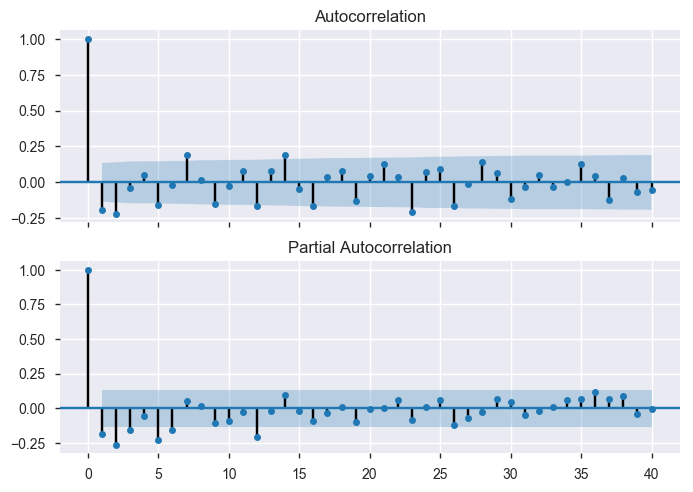

In [22]:
n = 40

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
sm.graphics.tsa.plot_acf(s_diff, lags=n, ax=ax1)
sm.graphics.tsa.plot_pacf(s_diff, lags=n, ax=ax2)
if save_image:
    fig.savefig('コレログラム(s_diff).png')

## PV / エントリ数

In [23]:
data = [
    Scatter(x=df.index, y=df.pv_per_entry, name='pv / entry'),
    Scatter(x=df.index, y=df.entry, name='entry')
]
fig = Figure(data=data, layout=Layout(title='1エントリあたりのPV数'))
iplot(fig, image=save_image, filename='1エントリあたりのPV数')

In [24]:
res = sm.tsa.seasonal_decompose(df.pv_per_entry, freq=7)
fig = tools.make_subplots(rows=4, cols=1)
fig.append_trace(Scatter(x=res.observed.index, y=res.observed, name='Original'), 1, 1)
fig.append_trace(Scatter(x=res.trend.index, y=res.trend, name='Trend'), 2, 1)
fig.append_trace(Scatter(x=res.seasonal.index, y=res.seasonal, name='Seasonal'), 3, 1)
fig.append_trace(Scatter(x=res.resid.index, y=res.resid, name='Resid'), 4, 1)
fig['layout'].update(title='成分分解(PV / エントリ数)')
iplot(fig, image=save_image, filename='成分分解(PV / エントリ数)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



# 予測

* 季節性をもつデータなので、[SARIMA](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)で予測を行う

## SARIMA

In [25]:
ts = df.pv
ts_train = df_train.pv
ts_test = df_test.pv

In [26]:
def fit_model(ts_train, order, seasonal_order):
    model = SARIMAX(
        ts_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False)
    result = model.fit()
    return result

def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci

def make_fig(ts, train_pred, test_pred, test_pred_ci, result, title='SARIMA'):
    data = [
        Scatter(x=ts.index, y=ts, name='Original', line=dict(dash='dot')),
        Scatter(x=train_pred.index, y=train_pred, name='Predict(train)'),
        Scatter(x=test_pred.index, y=test_pred, name='Predict(test)'),
        # Scatter(x=result.resid.index, y=result.resid, name='Resid')
    ]
    fig1 = Figure(data=data, layout=Layout(title=title))

    fig2, ax = plt.subplots()
    ts.plot(ax=ax, label='Original', linestyle="dashed")
    train_pred.plot(ax=ax, label='Predict(train)')
    test_pred.plot(ax=ax, label='Predict(test)')
    ax.fill_between(
        test_pred_ci.index,
        test_pred_ci.iloc[:, 0],
        test_pred_ci.iloc[:, 1],
        color='k',
        alpha=.2)
    ax.legend()
    ax.set_title(title)

    fig3, ax = plt.subplots()
    ts['2018-04-01':].plot(ax=ax, label='Original', linestyle="dashed")
    test_pred.plot(ax=ax, label='Predict(test)', color='g')
    ax.fill_between(
        test_pred_ci.index,
        test_pred_ci.iloc[:, 0],
        test_pred_ci.iloc[:, 1],
        color='k',
        alpha=.2)
    ax.legend()
    ax.set_title(title)

    return fig1, fig2, fig3

### arma_order_select_ic

* [arma_order_select_ic](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html)を用いて、パラメータを決める
* AIC min: p=2, q=6

In [27]:
s_diff_train = s_diff[s_diff.index < '2018-04-01']
res = sm.tsa.arma_order_select_ic(s_diff_train, max_ar=5, max_ma=7, ic='aic')
res.aic_min_order

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversion

(2, 6)

In [28]:
order=(2,1,6)
seasonal_order=(1,1,1,7)
result = fit_model(ts_train, order, seasonal_order)
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
result.summary()

RMSE(train):	58.447
RMSE(test):	150.03


/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                pv   No. Observations:                  182
Model:             SARIMAX(2, 1, 6)x(1, 1, 1, 7)   Log Likelihood                -890.102
Date:                           Sun, 06 May 2018   AIC                           1802.205
Time:                                   18:48:56   BIC                           1837.449
Sample:                               10-01-2017   HQIC                          1816.492
                                    - 03-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6489      4.479     -0.145      0.885      -9.427       8.129
ar.L2          0.3797      4.560      0.083      0.934      -8.558       9.317
ma.L1          0.1962     13.725      0.014      0.989     -26.704      27.096
ma.L2         -0.9070     14.113     -0.064      0.949     -28.568      26.754
ma.L3         -0.1296      2.655     -0.049      0.961      -5.332       5.073
ma.L4         -0.0245      1.562     -0.016      0.987      -3.085       3.036
ma.L5         -0.0177      0.970     -0.018      0.985      -1.918       1.883
ma.L6         -0.0197      0.420     -0.047      0.963      -0.844       0.804
ar.S.L7       -0.2623      0.231     -1.135      0.256      -0.715       0.190
ma.S.L7       -0.6646      0.232     -2.868      0.004      -1.119      -0.210
sigma2      3837.1275   5.99e+04      0.064      0.949   -1.14e+05    1.21e+05
===================================================================================
Ljung-Box (Q):                       18.96   Jarque-Bera (JB):             24679.04
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.05   Skew:                             6.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

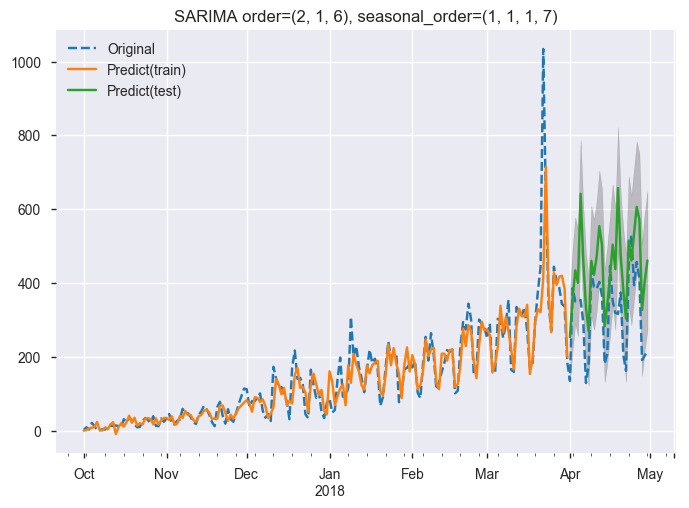

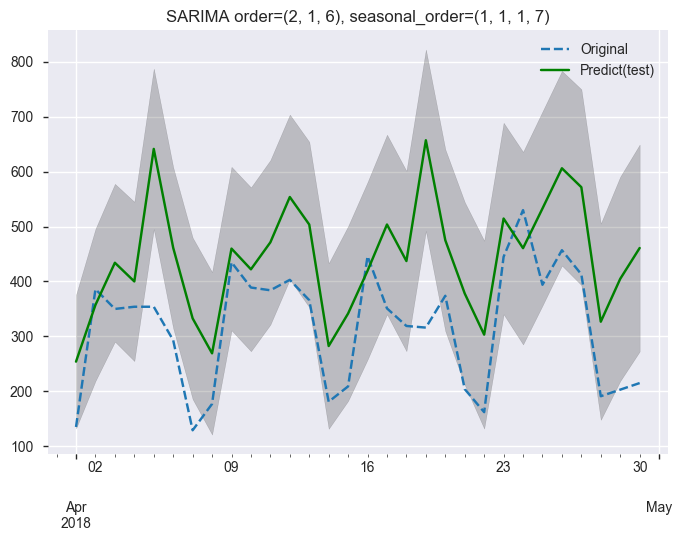

In [29]:
title = 'SARIMA order={}, seasonal_order={}'.format(order, seasonal_order)
fig1, fig2, fig3 = make_fig(ts, train_pred, test_pred, test_pred_ci, result, title)
iplot(fig1, image=save_image, filename='SARIMA1-1')
if save_image:
    fig2.savefig('SARIMA1-2')
    fig3.savefig('SARIMA1-3')

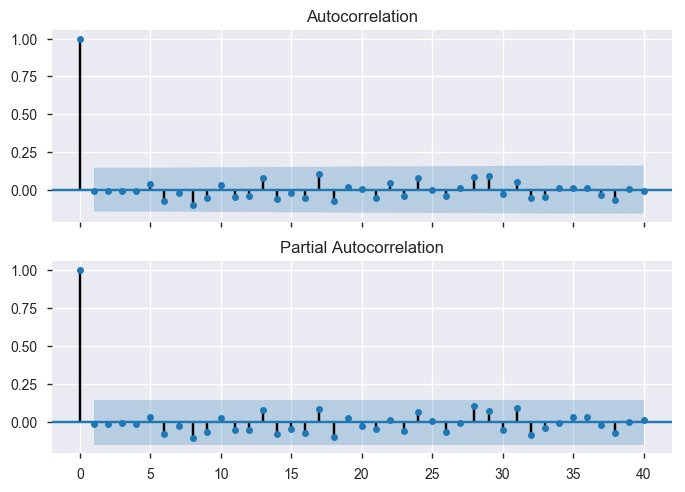

In [30]:
n = 40
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
sm.graphics.tsa.plot_acf(result.resid, lags=n, ax=ax1)
sm.graphics.tsa.plot_pacf(result.resid, lags=n, ax=ax2)
if save_image:
    fig.savefig('残差1')

### Grid Search

* Grid Searchでパラメータ探索
    * test-rmseも計算するが使わない（本来は未知であるため）

In [31]:
p_range = range(0, 6)
d_range = range(0, 4)
q_range = range(0, 8)
sp_range = range(0, 2)
sd_range = range(0, 2)
sq_range = range(0, 2)
history = pd.DataFrame()
for p, d, q, sp, sd, sq in itertools.product(p_range, d_range, q_range, sp_range, sd_range, sq_range):
    if p == 0 and q == 0:
        continue
    model = SARIMAX(
        ts_train,
        order=(p, d, q),
        seasonal_order=(sp, sd, sq, 7),
        enforce_stationarity=False,
        enforce_invertibility=False)
    result = model.fit()
    train_pred = result.predict()
    test_pred = result.forecast(len(df_test))
    history = history.append(
        pd.Series({
            'p': p,
            'd': d,
            'q': q,
            'sp': sp,
            'sd': sd,
            'sq': sq,
            'aic': result.aic,
            'bic': result.bic,
            'train-rmse': np.sqrt(mean_squared_error(ts_train, train_pred)),
            'test-rmse': np.sqrt(mean_squared_error(ts_test, test_pred))
        }),
        ignore_index=True)

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

M

In [32]:
history.sort_values(by='aic').head()

,aic,bic,d,p,q,sd,sp,sq,test-rmse,train-rmse
607,1788.577241,1827.025322,1.0,2.0,7.0,1.0,1.0,1.0,213.233196,56.551452
859,1788.745876,1827.193957,1.0,3.0,7.0,1.0,0.0,1.0,113.702525,56.803243
1115,1789.378411,1831.030497,1.0,4.0,7.0,1.0,0.0,1.0,135.805266,56.125318
1119,1789.942875,1834.798969,1.0,4.0,7.0,1.0,1.0,1.0,157.814221,56.008527
111,1790.310009,1822.350076,1.0,0.0,7.0,1.0,1.0,1.0,156.144135,58.798796


In [33]:
history.sort_values(by='train-rmse').head()

,aic,bic,d,p,q,sd,sp,sq,test-rmse,train-rmse
1113,1859.642120,1901.294207,1.0,4.0,7.0,0.0,0.0,1.0,113.475712,53.923458
1369,1856.598062,1901.454155,1.0,5.0,7.0,0.0,0.0,1.0,112.341062,53.937692
1373,1858.913330,1906.973430,1.0,5.0,7.0,0.0,1.0,1.0,115.611538,53.990284
1361,1869.243645,1910.895732,1.0,5.0,6.0,0.0,0.0,1.0,112.119264,53.996537
1372,1886.285779,1931.141873,1.0,5.0,7.0,0.0,1.0,0.0,126.945872,54.306539


In [34]:
history.sort_values(by='test-rmse').head()

,aic,bic,d,p,q,sd,sp,sq,test-rmse,train-rmse
226,2033.558278,2039.966291,0.0,1.0,0.0,1.0,0.0,0.0,59.381694,80.715324
234,2024.857090,2034.469110,0.0,1.0,1.0,1.0,0.0,0.0,59.520844,80.706696
482,2024.849634,2034.461654,0.0,2.0,0.0,1.0,0.0,0.0,59.561665,80.705050
554,2018.883701,2031.699728,1.0,2.0,1.0,1.0,0.0,0.0,61.536567,80.813581
306,2008.047838,2020.863864,1.0,1.0,2.0,1.0,0.0,0.0,62.031098,80.816687


In [35]:
order=(2,1,7)
seasonal_order=(1,1,1,7)
result = fit_model(ts_train, order, seasonal_order)
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
result.summary()

RMSE(train):	56.551
RMSE(test):	213.23


/Users/yusuke/.local/share/virtualenvs/time-series-pv-_LrVelOM/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                pv   No. Observations:                  182
Model:             SARIMAX(2, 1, 7)x(1, 1, 1, 7)   Log Likelihood                -882.289
Date:                           Sun, 06 May 2018   AIC                           1788.577
Time:                                   19:12:04   BIC                           1827.025
Sample:                               10-01-2017   HQIC                          1804.164
                                    - 03-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7341      0.602     -1.220      0.223      -1.913       0.445
ar.L2         -0.6721      0.353     -1.902      0.057      -1.365       0.021
ma.L1          0.3005      0.646      0.465      0.642      -0.965       1.566
ma.L2          0.1380      0.287      0.482      0.630      -0.424       0.699
ma.L3         -0.7480      0.381     -1.961      0.050      -1.496      -0.000
ma.L4         -0.2445      0.425     -0.575      0.565      -1.077       0.588
ma.L5         -0.1649      0.322     -0.512      0.609      -0.796       0.466
ma.L6         -0.1059      0.260     -0.408      0.684      -0.615       0.404
ma.L7          0.1592      0.357      0.446      0.656      -0.540       0.859
ar.S.L7       -0.6176      0.249     -2.484      0.013      -1.105      -0.130
ma.S.L7       -0.6251      0.271     -2.309      0.021      -1.156      -0.095
sigma2      4736.6494    822.241      5.761      0.000    3125.087    6348.212
===================================================================================
Ljung-Box (Q):                       17.50   Jarque-Bera (JB):             14827.61
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.90   Skew:                             5.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

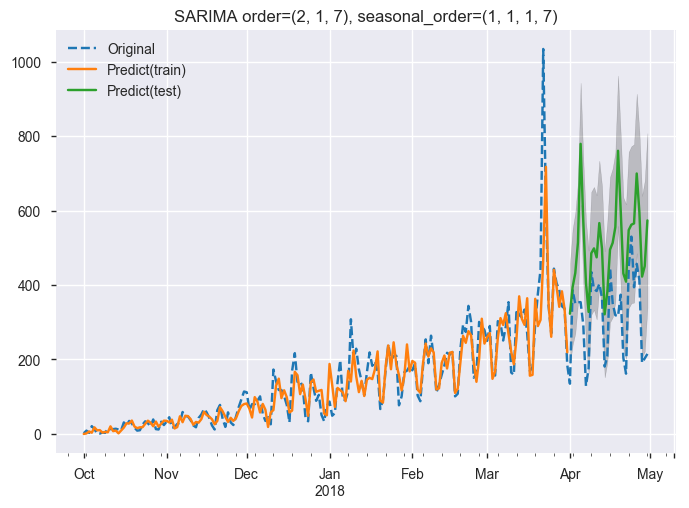

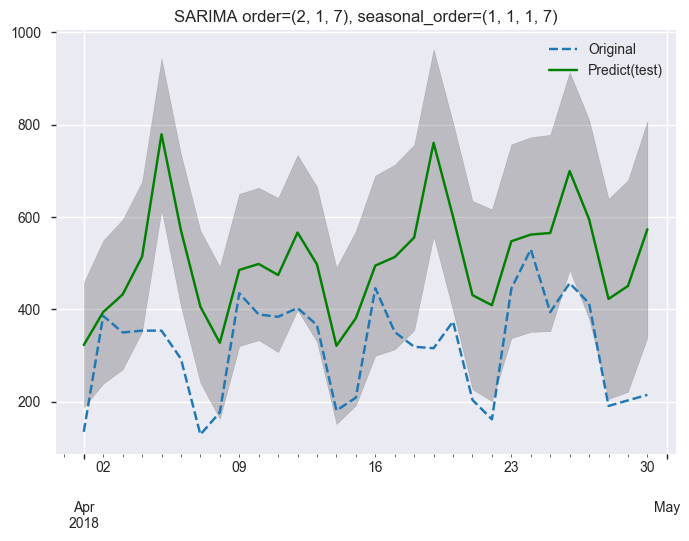

In [36]:
title = 'SARIMA order={}, seasonal_order={}'.format(order, seasonal_order)
fig1, fig2, fig3 = make_fig(ts, train_pred, test_pred, test_pred_ci, result, title)
iplot(fig1, image=save_image, filename='SARIMA1-1')
if save_image:
    fig2.savefig('SARIMA1-2')
    fig3.savefig('SARIMA1-3')